In [2]:
import json, requests, os, threading, time
from urllib.parse import urlencode, quote_plus
from types import SimpleNamespace
from abc import ABC, abstractmethod
from dateutil import tz, parser
from dateutil.tz import tzlocal
from datetime import datetime, timedelta
from copy import deepcopy


def timestamp2datetime(timestamp, convert_to_local=True):
  ''' Converts UNIX timestamp to a datetime object. '''
  if isinstance(timestamp, (int)):
    dt = datetime.utcfromtimestamp(timestamp)
    if convert_to_local: # 是否轉化為本地時間
      dt = dt + timedelta(hours=8) # 預設時區
      dt = json.dumps(dt.isoformat())
    return dt
  return json.dumps(timestamp.isoformat())

In [3]:
from google.colab import drive
drive.mount('/content/drive')
FilePath = '/content/drive/MyDrive/Colab Notebooks/PAPPER/'
print(os.listdir(FilePath))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
['.ipynb_checkpoints', 'BitPro_BTC-TWD.json', 'OUTPUT', 'TEST.json', '30_ACE_USDT-TWD.json', '30_BitPro_USDT-TWD.json', 'OUTPUT30_ACE_USDT-TWD.json', 'OUTPUT30_BitPro_USDT-TWD.json', '30_ACE_BTC-TWD.json', '30_BitPro_BTC-TWD.json', 'OUTPUT30_BitPro_BTC-TWD.json', 'OUTPUT30_ACE_BTC-TWD.json', '30_ACE_ETH-TWD.json', 'OUTPUT30_ACE_ETH-TWD.json', 'OUTPUT30_BitPro_ETH-TWD.json', '30_BitPro_ETH-TWD.json']


# 爬數據

In [ ]:
class Pattern(ABC):
  def __init__(self,name,baseUrl,argBegin,argEnd,argInterval,timeBegin,timeEnd,interval,unit):
    self.__name = name
    self.__baseUrl = baseUrl
    self.__argBegin = argBegin
    self.__argEnd = argEnd
    self.__argInterval = argInterval
    self.__interval = interval
    self.__timeBegin = timeBegin
    self.__timeEnd = timeEnd
    self.__unit = unit
  
  def SetInterval(self,interval):
    self.__interval = interval

  def GetInterval(self,interval):
    return self.__interval

  def SetTimeRange(self,timeBegin,timeEnd):
    self.__timeBegin = timeBegin
    self.__timeEnd = timeEnd

  def ReqFirst(self):
    timeEnd = self.__timeBegin + self.__interval*60*2*self.__unit
    payload = {self.__argInterval:self.__interval, self.__argBegin:self.__timeBegin, self.__argEnd:timeEnd}
    url_payload = urlencode(payload, quote_via=quote_plus)
    r = requests.get(self.__baseUrl+'&'+url_payload)
    data = json.loads(r.content.decode(), object_hook=lambda d: SimpleNamespace(**d))
    tmp = json.loads('[]')
    tmp.append(self.Parse_data(data)[0])
    self.__write_json(tmp)

  def Req(self):
    filename = FilePath+self.__name+'.json'
    with open(filename,'r') as file:
      file_data = file.read().rstrip()
      file_data = json.loads(file_data, object_hook=lambda d: SimpleNamespace(**d))
      file.close()
    timeBegin = (file_data[int(len(file_data)-1)].t + self.__interval*60) * self.__unit
    timeEnd = timeBegin + self.__interval*60*2000*self.__unit
    payload = {self.__argInterval:self.__interval, self.__argBegin:timeBegin, self.__argEnd:timeEnd}
    url_payload = urlencode(payload, quote_via=quote_plus)
    r = requests.get(self.__baseUrl+'&'+url_payload)
    data = json.loads(r.content.decode(), object_hook=lambda d: SimpleNamespace(**d))
    self.__write_json(self.Parse_data(data))

  def GoReq(self):
    f_break = False
    while not f_break:
      filename = FilePath+self.__name+'.json'
      with open(filename,'r') as file:
        file_data = file.read().rstrip()
        file_data = json.loads(file_data, object_hook=lambda d: SimpleNamespace(**d))
        file.close()
      now = int(datetime.now().timestamp())
      timeBegin = int(file_data[int(len(file_data)-1)].t + self.__interval*60)
      if timeBegin >= now:
        break
      if now - timeBegin >= self.__interval*60*2000:
        timeEnd = timeBegin + self.__interval*60*2000
      else:
        timeEnd = now
        f_break = True

      payload = {self.__argInterval:self.__interval, self.__argBegin:timeBegin*self.__unit, self.__argEnd:timeEnd*self.__unit}
      url_payload = urlencode(payload, quote_via=quote_plus)
      r = requests.get(self.__baseUrl+'&'+url_payload)
      data = json.loads(r.content.decode(), object_hook=lambda d: SimpleNamespace(**d))
      self.__write_json(self.Parse_data(data))
      # self.Insert_json()

  def __write_json(self, new_data):
    filename = FilePath+self.__name+'.json'
    if os.path.exists(filename):
      append_write = 'r+' # append if already exists
    else:
      append_write = 'w+' # make a new file if not

    with open(filename,append_write) as file:
      if os.stat(filename).st_size != 0:
        # First we load existing data into a dict.
        file_data = json.load(file)
        # Join new_data with file_data inside emp_details
        file_data = file_data + new_data
        # Sets file's current position at offset.
        file.seek(0)
        # convert back to json.
        json.dump(file_data, file, indent=2)
      else:
        file.seek(0)
        json.dump(new_data, file, indent=2)
      file.close()

  def Insert_json(self):
    filename = FilePath+self.__name+'.json'
    out_file = '/content/drive/MyDrive/Colab Notebooks/PAPPER/OUTPUT'+self.__name+'.json'
    if os.path.exists(out_file):
      os.remove(out_file)
      append_write = 'w+' # append if already exists
    else:
      append_write = 'w+' # make a new file if not

    with open(filename,'r') as file:
      file_data = file.read().rstrip()
      data = json.loads(file_data, object_hook=lambda d: SimpleNamespace(**d))
      file.close()

    print(self.__name,' preInsert Number: ',len(data))
    sum_lose = 0
    begin = 1577808000
    time_cross = self.__interval*60
    out_data = deepcopy(data)
    trash_index = []
    for i in range(len(data)):
      if data[i].t != begin:
        lose = int((data[i].t - begin)/time_cross)
        # if lose < 0:
          # trash_index.append(i)
          # print(lose,data[i].iso,timestamp2datetime(begin))
          # continue
        insert_tmp = deepcopy(data[i-1])
        insert_tmp.v = 0
        insert_tmp.o = insert_tmp.c
        insert_tmp.h = insert_tmp.c
        insert_tmp.l = insert_tmp.c
        for x in range(lose):
          insert_tmp.t = deepcopy(data[i-1].t) #reset insert_tmp.t
          insert_tmp.t = insert_tmp.t + time_cross*(x+1)
          insert_tmp.iso = timestamp2datetime(insert_tmp.t)
          out_data.insert(i+x+sum_lose,deepcopy(insert_tmp))
          begin = data[i].t
        sum_lose += lose
      begin += time_cross

    # if len(trash_index) != 0:
    #   for v in trash_index:
    #     print(self.__name,v,out_data[v].iso)
    #     # del out_data[v]

    print(self.__name,' postInsert Number: ',len(out_data))
    with open(out_file,append_write) as file:
      file.seek(0)
      json.dump(self.__post_prase_data(out_data), file, indent=2)
      file.close()   

  def __post_prase_data(self, origin_data):
    out = json.loads('[]')
    attr = ["iso","t","h","l","o","c","v"]
    for v in origin_data:
      temp = {}
      temp.update({"iso":v.iso})
      temp.update({"t":v.t})
      temp.update({"h":v.h})
      temp.update({"l":v.l})
      temp.update({"o":v.o})
      temp.update({"c":v.c})
      temp.update({"v":v.v})
      out.append(temp)
    return out

  @abstractmethod
  def Parse_data(self, origin_data):
    pass


def GoReq(*Patterns):
  for pat in Patterns:
    threading.Thread(target=pat.GoReq()).start()

In [ ]:
class ACE(Pattern):
  def Parse_data(self, origin_data):
    out = json.loads('[]')
    for v in origin_data.attachment:
      out.append({"iso":timestamp2datetime(int(v.currentTime/1000)),"t":int(v.currentTime/1000),"h":int(v.highPrice),"l":int(v.lowPrice),"o":int(v.openPrice),"c":int(v.closePrice),"v":v.volume})
    return out



class BitPro(Pattern):
  def Parse_data(self, origin_data):
    out = json.loads('[]')
    attr = ["t","h","l","o","c","v"]
    for v in origin_data:
      temp = {}
      temp.update({"iso":timestamp2datetime(v[0])})
      for i in range(len(v)):
        temp.update({attr[i]:v[i]})
      out.append(temp)
    return out


In [ ]:
ace_usdt = ACE("30_ACE_USDT-TWD","https://ace.io/polarisex/quote/getKline?baseCurrencyId=1&tradeCurrencyId=14","startTime","endTime","type",1577806200000,1581408000000,30,1000)
bit_usdt = BitPro("30_BitPro_USDT-TWD","https://tradingview.bitopro.com/trading_datas/history?symbol=USDT_TWD","from","to","resolution",1577808000,1581408000,30,1)

# ace_usdt.ReqFirst()
# bit_usdt.ReqFirst()

GoReq(ace_usdt,bit_usdt)

ace_usdt.Insert_json()
bit_usdt.Insert_json()

30_ACE_USDT-TWD  preInsert Number:  43309
30_ACE_USDT-TWD  postInsert Number:  43332
30_BitPro_USDT-TWD  preInsert Number:  42020
30_BitPro_USDT-TWD  postInsert Number:  43332


In [ ]:
ace_eth = ACE("30_ACE_ETH-TWD","https://ace.io/polarisex/quote/getKline?baseCurrencyId=1&tradeCurrencyId=4","startTime","endTime","type",1577806200000,1581408000000,30,1000)
bit_eth = BitPro("30_BitPro_ETH-TWD","https://tradingview.bitopro.com/trading_datas/history?symbol=ETH_TWD","from","to","resolution",1577808000,1581408000,30,1)

# ace_eth.ReqFirst()
# bit_eth.ReqFirst()

GoReq(ace_eth,bit_eth)

ace_eth.Insert_json()
bit_eth.Insert_json()

30_ACE_ETH-TWD  preInsert Number:  43347
30_ACE_ETH-TWD  postInsert Number:  43374
30_BitPro_ETH-TWD  preInsert Number:  40827
30_BitPro_ETH-TWD  postInsert Number:  43374


In [ ]:
#BTC

ace_btc = ACE("30_ACE_BTC-TWD","https://ace.io/polarisex/quote/getKline?baseCurrencyId=1&tradeCurrencyId=2","startTime","endTime","type",1577806200000,1581408000000,30,1000)
bit_btc = BitPro("30_BitPro_BTC-TWD","https://tradingview.bitopro.com/trading_datas/history?symbol=BTC_TWD","from","to","resolution",1577808000,1581408000,30,1)

# ace_btc.ReqFirst()
# bit_btc.ReqFirst()

GoReq(ace_btc,bit_btc)

ace_btc.Insert_json()
bit_btc.Insert_json()

out_file = '/content/drive/MyDrive/Colab Notebooks/PAPPER/OUTPUT30_ACE_BTC-TWD.json'
with open(out_file,'r') as file:
  file_data = file.read().rstrip()
  data = json.loads(file_data, object_hook=lambda d: SimpleNamespace(**d))
  file.close()
os.remove(out_file)

del data[24236]
print(data[24236])

out = json.loads('[]')
attr = ["iso","t","h","l","o","c","v"]
for v in data:
  temp = {}
  temp.update({"iso":v.iso})
  temp.update({"t":v.t})
  temp.update({"h":v.h})
  temp.update({"l":v.l})
  temp.update({"o":v.o})
  temp.update({"c":v.c})
  temp.update({"v":v.v})
  out.append(temp)
open(out_file,'w').write(
    json.dumps(out, indent=2)
) 

30_ACE_BTC-TWD  preInsert Number:  86046
30_ACE_BTC-TWD  postInsert Number:  86077
30_BitPro_BTC-TWD  preInsert Number:  82035
30_BitPro_BTC-TWD  postInsert Number:  84787
namespace(c=968570, h=968570, iso='"2021-05-19T22:00:00"', l=968570, o=968570, t=1621432800, v=0.0)


12520651

# 數據處理

In [8]:
from numpy import *
import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend. figure_format = 'retina'
import pandas as pd
pd.core.common.is_list_like = pd.api.types.is_list_like
import pandas_datareader as web
import matplotlib.pyplot as plt # 基本畫圖
from matplotlib.gridspec import GridSpec # 畫圖網格佈局
!pip install plotly
!pip install mplfinance

import numpy as np
import plotly.graph_objects as go
from plotly.offline import plot
from mplfinance.original_flavor import candlestick2_ohlc

__name1 = 'OUTPUT30_BitPro_BTC-TWD'
time_cross = 1800
__name2 = 'OUTPUT30_ACE_BTC-TWD'
# time_cross = 600

begin = 1577808000
end = 1646301600
filename1 = FilePath+__name1+'.json'
filename2 = FilePath+__name2+'.json'
with open(filename1,'r') as file:
  file_data = file.read().rstrip()
  data1 = json.loads(file_data, object_hook=lambda d: SimpleNamespace(**d))
  file.close()
with open(filename2,'r') as file:
  file_data = file.read().rstrip()
  data2 = json.loads(file_data, object_hook=lambda d: SimpleNamespace(**d))
  file.close()



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [9]:
attr = ["iso","t","High","Low","Open","Close","Volume"]

def To_PdData(in_data): 
  out_dd = []
  for v in in_data:
    temp = []
    temp.clear()
    temp.append(v.iso)
    temp.append(int(v.t))
    temp.append(int(v.h))
    temp.append(int(v.l))
    temp.append(int(v.o))
    temp.append(int(v.c))
    temp.append(int(v.v))
    out_dd.append(temp)
  return(pd.DataFrame(out_dd, columns=attr))

def Draw_Candle(pdd, title):
  pdd['iso']= (pd.to_datetime(pdd['t'], unit='s', utc=True, infer_datetime_format=True)+ pd.Timedelta('08:00:00')).dt.strftime('%Y%m%d') # 簡化x軸顯示
  # k線
  fig = go.Figure(data=[go.Candlestick(x=pdd['iso'],
                open=pdd['Open'], 
                high=pdd['High'],
                low=pdd['Low'], 
                close=pdd['Close'])
                ])

  fig.update_layout(xaxis_rangeslider_visible=False, title=title)

  fig.show()


def Draw_Line(pdd1, pdd2, tittle):
  fig2 = plt.figure(figsize=(20,6),dpi=100)
  plt.plot(pdd1['iso'], pdd1['p'], 'b', label='BitoPro')
  plt.plot(pdd2['iso'], pdd2['p'], 'r', label='ACE')
  ax = plt.gca()
  ax.yaxis.grid(True)
  pdd1['iso']= (pd.to_datetime(pdd1['t'], unit='s', utc=True, infer_datetime_format=True)+ pd.Timedelta('08:00:00')).dt.strftime('%Y%m%d') # 簡化x軸顯示
  pdd2['iso']= (pd.to_datetime(pdd2['t'], unit='s', utc=True, infer_datetime_format=True)+ pd.Timedelta('08:00:00')).dt.strftime('%Y%m%d') # 簡化x軸顯示
  plt.xticks(range(0,len(pdd1['iso']),int(43200/time_cross/2)))
  fig2.autofmt_xdate(rotation=270)
  # plt.tick_params(
  #   axis='x',          # changes apply to the x-axis
  #   which='both',      # both major and minor ticks are affected
  #   bottom=False,      # ticks along the bottom edge are off
  #   top=False,         # ticks along the top edge are off
  #   labelbottom=False) # labels along the bottom edge are off
  # plt.xlabel('SEASON')
  # plt.xticks(Wade.SEASON_ID,rotation='vertical') #因兩人賽季數相同，故任選
  # plt.title('LeBron James and Dwyane Wade')
  fig2.suptitle(tittle)
  plt.legend(loc = 'lower left')
  plt.show()

# Draw_Candle(To_PdData(data1), '30_BitPro_BTC-TWD')
# Draw_Candle(To_PdData(data2), '30_ACE_BTC-TWD')

35
4.751986073847771


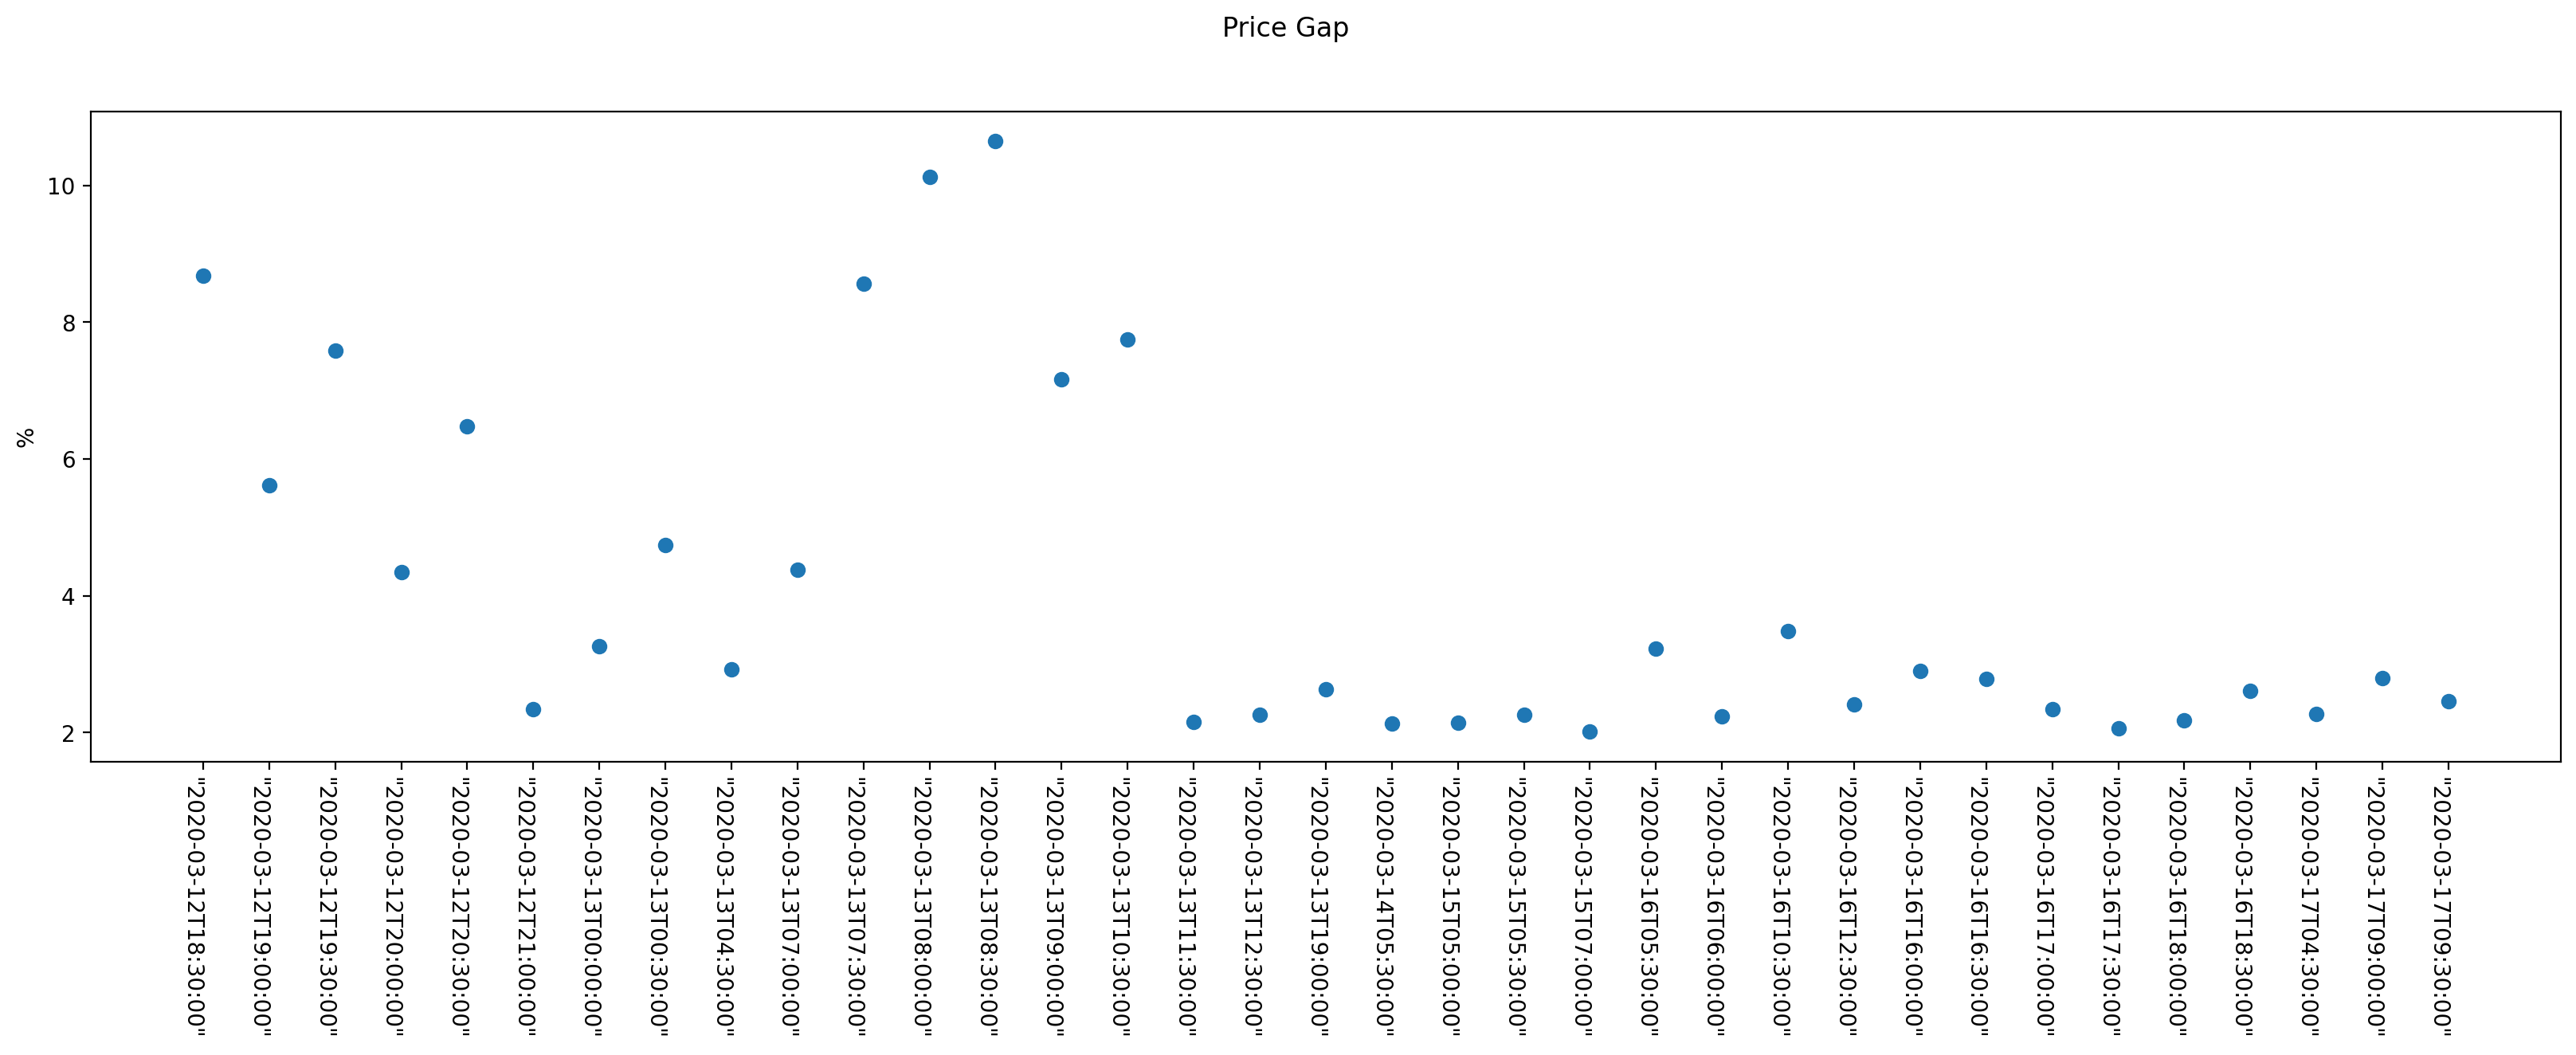

In [18]:
def Cacu(data1, data2, start, end):
  sum_price= 1.172
  nx=[]
  ny=[]
  f_start=0
  f_end=0
  avr1 = json.loads('[]')
  avr2 = json.loads('[]')
  for i in range(len(data1)):
    if data1[i].t < start:
      f_start=i
      continue
    if data1[i].t > end:
      f_end=i
      break
    if data1[i].t != data2[i].t:
      print('T pass',i,i,data1[i].iso,data2[i].iso)
      f_end=i
      break
    data1_pass = False
    data2_pass = False
    if data1[i].v == 0:
      data1_pass=True
    if data2[i].v == 0:
      data2_pass=True  
    if data1_pass and data2_pass:
      # print('V　pass',data1[i].iso)
      continue
    d1=(data1[i].h+data1[i].l)/2
    temp1 = {}
    temp1.update({"p":d1})
    temp1.update({"t":data1[i].t})
    temp1.update({"iso":data1[i].iso})
    avr1.append(temp1)
    d2=(data2[i].h+data2[i].l)/2
    temp2 = {}
    temp2.update({"p":d2})
    temp2.update({"t":data2[i].t})
    temp2.update({"iso":data2[i].iso})
    avr2.append(temp2)
    if d2 > d1:
      t = (d2/d1-1)*100
      if t > :
        nx.append(data1[i].iso)
        ny.append(t)
        sum_price = sum_price * (1+(t / 100))
        # print(sum_price)
    if d1 > d2:
      t = (d1/d2-1)*100
      if t > 2:
        nx.append(data1[i].iso)
        ny.append(t)
        sum_price = sum_price * (1+(t / 100))
        # print(sum_price)
  
  print(len(ny))
  print(sum_price)
  fig = plt.figure(figsize=(20,6),dpi=100)
  fig.suptitle('Price Gap')
  plt.scatter(nx,ny)
  fig.autofmt_xdate(rotation=270)
  plt.xticks(range(0,len(nx),int(3600/time_cross/2)))
  plt.ylabel('%', fontsize=10)


  # Draw_Candle(To_PdData(data1[f_start+1:f_end]), __name1[6:])
  # Draw_Candle(To_PdData(data2[f_start+1:f_end]), __name2[6:])
  # dfv1 = pd.DataFrame(avr1)
  # dfv2 = pd.DataFrame(avr2)
  # Draw_Line(dfv1,dfv2,'BTC-TWD')


Cacu(data1,data2,1582992000,1584633600)

In [ ]:
def echo_data(d):
  print('時間:'+str(datetime.fromisoformat(json.loads(d.iso))))
  print(str(d.t))
  print('開盤價:'+str(d.o))
  print('最高價:'+str(d.h))
  print('最低價:'+str(d.l))
  print('收盤價:'+str(d.c))
  print('成交量:'+str(d.v))

In [ ]:
__name = 'OUTPUT30_BitPro_BTC-TWD'
time_cross = 1800
# __name = '10_ACE_BTC-TWD'
# time_cross = 600

begin = 1577808000
filename = FilePath+__name+'.json'
with open(filename,'r') as file:
  file_data = file.read().rstrip()
  data = json.loads(file_data, object_hook=lambda d: SimpleNamespace(**d))
  file.close()

print(len(data))
lose = 0
for i in range(len(data)):
  if data[i].t != begin:
    # echo_data(data[i])
    # print(timestamp2datetime(begin))
    lose += int((data[i].t - begin)/time_cross)
    begin = data[i].t
  begin += time_cross
print(lose)
echo_data(data[len(data)-1])

38066
0
時間:2022-03-04 00:30:00
1646325000
開盤價:1202163
最高價:1203208
最低價:1202163
收盤價:1203208
成交量:0.01662266


In [ ]:
def T_post_prase_data(origin_data):
  out = json.loads('[]')
  attr = ["iso","t","h","l","o","c","v"]
  for v in origin_data:
    temp = {}
    temp.update({"iso":v.iso})
    temp.update({"t":v.t})
    temp.update({"h":v.h})
    temp.update({"l":v.l})
    temp.update({"o":v.o})
    temp.update({"c":v.c})
    temp.update({"v":v.v})
    out.append(temp)
  return out  

# del data2[24236]
print(data2[24236])
open('/content/drive/MyDrive/Colab Notebooks/PAPPER/OUTPUTt','w').write(
    json.dumps(T_post_prase_data(data2), indent=2)
) 

namespace(c=968570, h=968570, iso='"2021-05-19T22:00:00"', l=968570, o=968570, t=1621432800, v=0.0)


5856615

In [ ]:
__name = '30_BitPro_BTC-TWD'
filename = FilePath+__name+'.json'
with open(filename,'r') as file:
  file_data = file.read().rstrip()
  data = json.loads(file_data, object_hook=lambda d: SimpleNamespace(**d))
  file.close()

print(len(data))
echo_data(data[len(data)-1])

35382
時間:2022-02-24 11:00:00
1645671600
開盤價:1007791
最高價:1014714
最低價:1000000
收盤價:1000000
成交量:1.85718432


In [ ]:
def T_post_prase_data(origin_data):
  out = json.loads('[]')
  attr = ["iso","t","h","l","o","c","v"]
  for v in origin_data:
    temp = {}
    temp.update({"iso":v.iso})
    temp.update({"t":v.t})
    temp.update({"h":v.h})
    temp.update({"l":v.l})
    temp.update({"o":v.o})
    temp.update({"c":v.c})
    temp.update({"v":v.v})
    out.append(temp)
  # return out  

t_name = 'TEST'
filename = '/content/drive/MyDrive/Colab Notebooks/PAPPER/'+t_name+'.json'
out_file = '/content/drive/MyDrive/Colab Notebooks/PAPPER/OUTPUT'+t_name+'.json'
if os.path.exists(out_file):
  os.remove(out_file)
  append_write = 'w+' # append if already exists
else:
  append_write = 'w+' # make a new file if not

with open(filename,'r') as file:
  file_data = file.read().rstrip()
  data = json.loads(file_data, object_hook=lambda d: SimpleNamespace(**d))
  file.close()

sum_lose = 0
begin = 1577808000
end = data[len(data)-1].t
time_cross = 1800
out_data = copy.deepcopy(data)
for i in range(len(data)):
  if data[i].t != begin:
    lose = int((data[i].t - begin)/time_cross)
    insert_tmp = copy.deepcopy(data[i-1])
    insert_tmp.v = 0
    insert_tmp.o = insert_tmp.c
    insert_tmp.h = insert_tmp.c
    insert_tmp.l = insert_tmp.c
    for x in range(lose):
      insert_tmp.t = copy.deepcopy(data[i-1].t) #reset insert_tmp.t
      insert_tmp.t = insert_tmp.t + time_cross*(x+1)
      insert_tmp.iso = timestamp2datetime(insert_tmp.t)
      n=i+x+sum_lose
      out_data.insert(n,copy.deepcopy(insert_tmp))
      print(lose,n,insert_tmp.iso,out_data[n].iso)
      print('aaa',insert_tmp)
      print(out_data)
      begin = data[i].t
    
    sum_lose += lose
  begin = begin+time_cross
# with open(out_file,append_write) as file:
#   file.seek(0)
#   json.dump(post_prase_data(out_data), file, indent=2)
#   file.close()  

7 1 "2020-01-01T00:30:00" "2020-01-01T00:30:00"
aaa namespace(c=216780, h=216780, iso='"2020-01-01T00:30:00"', l=216780, o=216780, t=1577809800, v=0)
[namespace(c=216780, h=216887, iso='"2020-01-01T00:00:00"', l=216563, o=216563, t=1577808000, v=0.9976), namespace(c=216780, h=216780, iso='"2020-01-01T00:30:00"', l=216780, o=216780, t=1577809800, v=0), namespace(c=215838, h=215838, iso='"2020-01-01T04:00:00"', l=215838, o=215838, t=1577822400, v=0.0092662), namespace(c=215900, h=215900, iso='"2020-01-01T06:00:00"', l=215900, o=215900, t=1577829600, v=0.06596572)]
7 2 "2020-01-01T01:00:00" "2020-01-01T01:00:00"
aaa namespace(c=216780, h=216780, iso='"2020-01-01T01:00:00"', l=216780, o=216780, t=1577811600, v=0)
[namespace(c=216780, h=216887, iso='"2020-01-01T00:00:00"', l=216563, o=216563, t=1577808000, v=0.9976), namespace(c=216780, h=216780, iso='"2020-01-01T00:30:00"', l=216780, o=216780, t=1577809800, v=0), namespace(c=216780, h=216780, iso='"2020-01-01T01:00:00"', l=216780, o=216780

In [ ]:
print(out_data)
T_post_prase_data(out_data)

[namespace(c=216780, h=216887, iso='"2020-01-01T00:00:00"', l=216563, o=216563, t=1577808000, v=0.9976), namespace(c=216780, h=216780, iso='"2020-01-01T00:30:00"', l=216780, o=216780, t=1577809800, v=0), namespace(c=216734, h=216887, iso='"2020-01-01T01:00:00"', l=216717, o=216887, t=1577811600, v=0.783), namespace(c=215032, h=216800, iso='"2020-01-01T02:00:00"', l=214621, o=216734, t=1577813400, v=0.8567), namespace(c=215032, h=215032, iso='"2020-01-01T03:30:00"', l=215032, o=215032, t=1577820600, v=0), namespace(c=215032, h=215032, iso='"2020-01-01T03:30:00"', l=215032, o=215032, t=1577820600, v=0), namespace(c=215032, h=215032, iso='"2020-01-01T03:30:00"', l=215032, o=215032, t=1577820600, v=0), namespace(c=215032, h=215032, iso='"2020-01-01T03:30:00"', l=215032, o=215032, t=1577820600, v=0), namespace(c=215838, h=215838, iso='"2020-01-01T04:00:00"', l=215838, o=215838, t=1577822400, v=0.0092662), namespace(c=215838, h=215838, iso='"2020-01-01T05:30:00"', l=215838, o=215838, t=15778